In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

In [2]:
# Step 0: Define the neural network model, return logits instead of activation in forward method

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

# Step 2: Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 97.86%


In [3]:
# Step 6: Generate (untargeted) adversarial test examples

attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 50.59%


In [4]:
print(f'Shape of x_test_adv: {x_test_adv.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of x_test_adv: (10000, 1, 28, 28)
Shape of y_test: (10000, 10)


In [5]:
# Visualization
import matplotlib
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [6]:
def render_frame(image, logits, ground_truth):
    # actually draw the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

    # image
    ax1.imshow(image[0], cmap='gray')
    fig.sca(ax1)
    plt.xticks([])
    plt.yticks([])
    
    # classification
    probs = np.exp(logits) / sum(np.exp(logits))
    topk = probs.argsort()[::-1]
    topprobs = probs[topk]
    barlist = ax2.bar(range(10), topprobs)
    for i, v in enumerate(topk):
        if i == 0:
            barlist[i].set_color('r')
        if v == ground_truth:
            barlist[i].set_color('g')
        
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10), [i for i in topk])
    fig.subplots_adjust(bottom=0.1)

    # save the plot
    path = os.path.join('./adv-examples', f'gt-{ground_truth}.png')
    if os.path.exists(path):
        os.remove(path)
    plt.savefig(path)

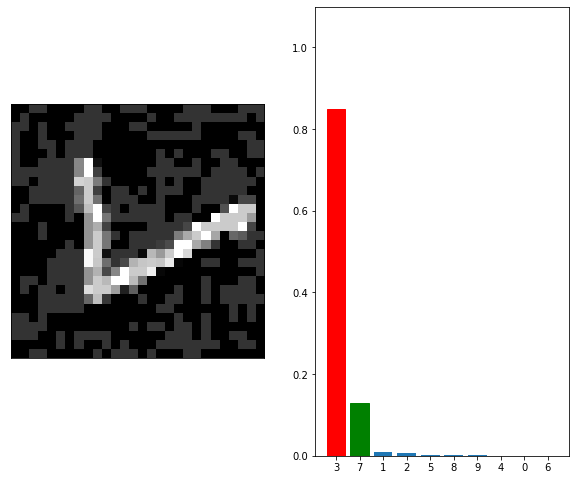

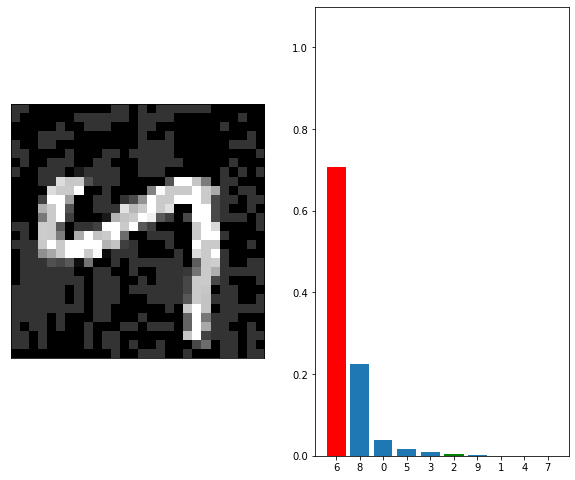

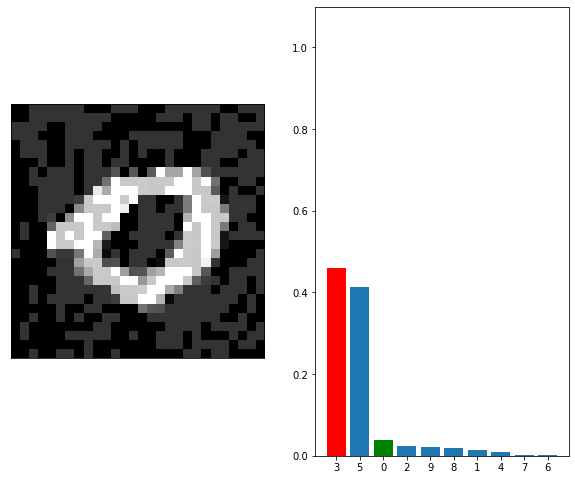

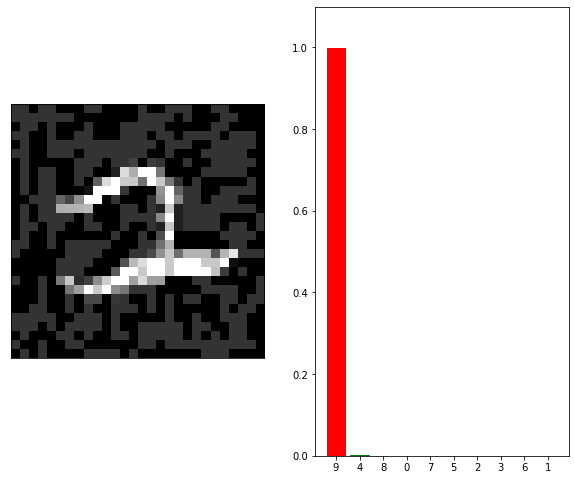

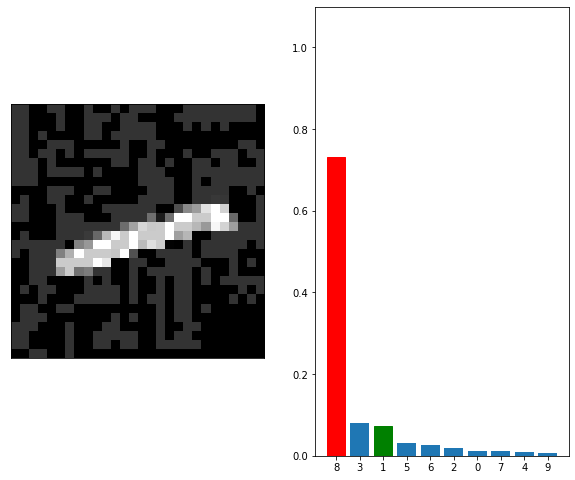

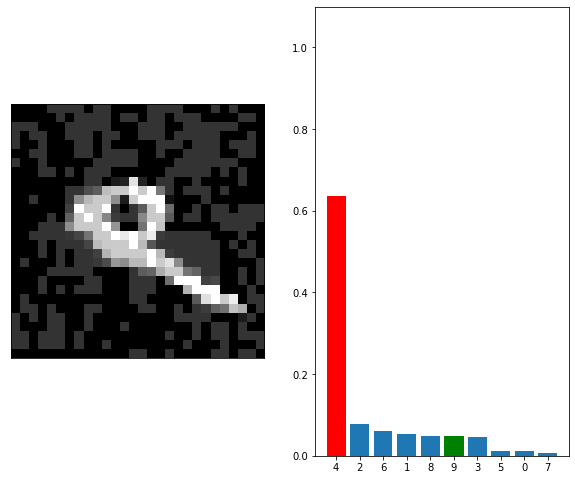

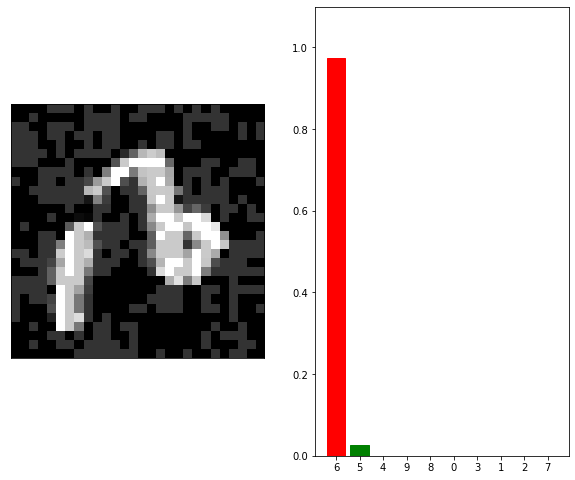

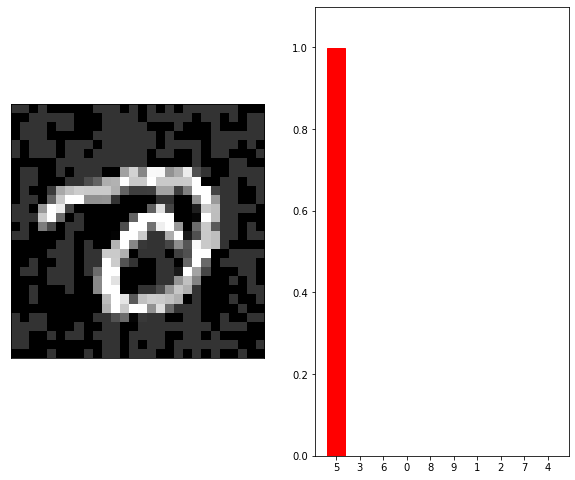

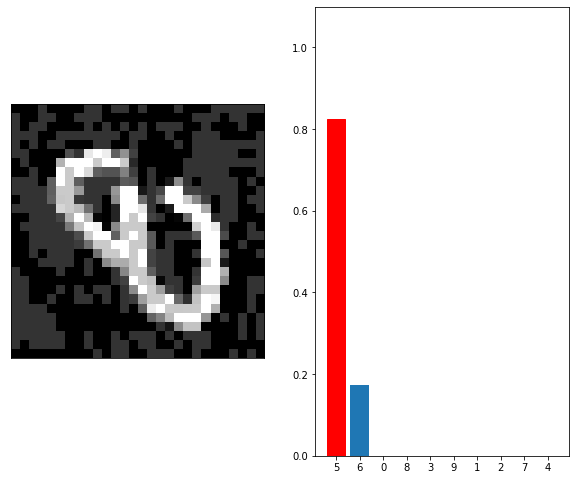

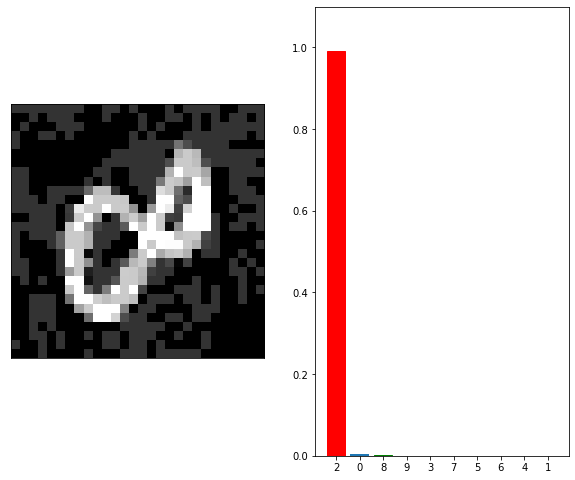

In [7]:
visited = []

for i in range(x_test_adv.shape[0]):
    if len(visited) == 10:
        break
    
    y = np.argmax(y_test[i])
    if y in visited:
        continue

    pred = np.argmax(predictions[i])
    if y == pred:
        continue
    
    visited.append(y)
    render_frame(x_test_adv[i], predictions[i], y)   